Download and Extract the Food-101 Dataset. 

In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 
!tar xzvf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

Import the necessary modules. 

In [60]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

%cd content/

%matplotlib inline

[Errno 2] No such file or directory: 'content/'
/content


Generating essential dictionaries and methods that will be make life simple.  

In [61]:
class_N = {}
N_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

# Method to generate directory-file map. 
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

# Method to recursively copy a directory.  
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

# Train files to ignore. 
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.    
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

# Method to load and resize images.  
def load_images(path_to_imgs):
  resize_count = 0
  
  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)
  
  return np.array(all_imgs), np.array(all_classes)

# Method to generate train-test files. 
def gen_train_test_split(path_to_imgs = 'food-101/images' , target_path = 'food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test


{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [62]:
# Generate train-test files. 
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    gen_train_test_split()  
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)

train and test folders already exists.
101 101


In [63]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

(384, 512, 3)


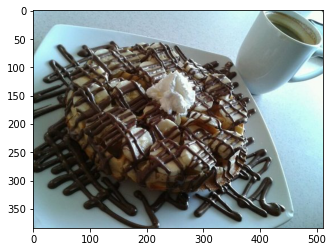

In [64]:
# Display an image. Brb. Gtg and get a waffle for myself. :P
sampleImage = imread('/content/food-101/test/waffles/1236559.jpg')
print(sampleImage.shape)
plt.imshow(sampleImage)

In [7]:
X_train, y_train, X_test, y_test = load_train_test_data('/content/food-101/train','/content/food-101/test')

Fitting the data on the Inception-v3 model.

In [8]:
tensorflow.keras.backend.clear_session()

n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = '/content/food-101/train'
test_data = '/content/food-101/test'
train_samples = 75750
test_samples = 25250

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit(train_gen, steps_per_epoch= train_samples // batch_size, validation_data= test_gen, validation_steps= test_samples // batch_size, epochs=30, callbacks=[csv_logger, checkpointer])

model.save('model_trained_101class.hdf5')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/30
4734/4734 [==============================] - 1067s 225ms/step - loss: 4.9407 - accuracy: 0.0616 - val_loss: 4.2642 - val_accuracy: 0.1995
Epoch 2/30
4734/4734 [==============================] - 940s 198ms/step - loss: 3.9720 - accuracy: 0.2322 - val_loss: 2.9427 - val_accuracy: 0.4301
Epoch 3/30
4734/4734 [==============================] - 937s 198ms/step - loss: 3.1980 - accuracy: 0.3630 - val_loss: 2.3596 - val_accuracy: 0.5322
Epoch 4/30
4734/4734 [==============================] - 944s 199ms/step - loss: 2.7665 - accuracy: 0.4433 - val_loss: 2.0358 - val_accuracy: 0.5941
Epoch 5/30
4734/4734 [==============================] - 961s 203ms/step - loss: 2.4826 - accuracy: 0.4981 - val_loss: 1.8426 - val_accuracy: 0.6304
Epoch 6/30
4734/4734 [==============================] - 946s 200ms/step - loss: 2.2733 - accuracy: 0.539

In [12]:
class_map_101 = train_gen.class_indices
class_map_101

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

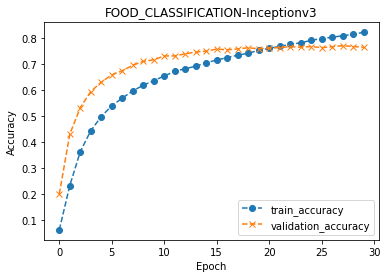

In [34]:
# Plot training-accuracy & validation-accuracy.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

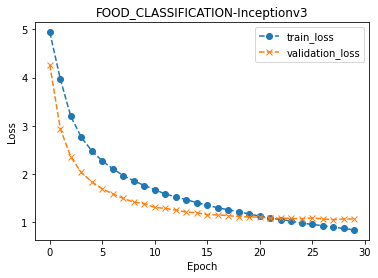

In [35]:
# Plot training-loss & validation-loss.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

In [65]:
# Loading the best saved model to make predictions.
tensorflow.keras.backend.clear_session()
model_best = load_model('best_model_101class.hdf5',compile = False)
# Downloading some test images.
!wget -O cupcakes.jpg https://cdn.sallysbakingaddiction.com/wp-content/uploads/2019/05/yellow-cupcakes-with-chocolate-frosting-sprinkles.jpg
!wget -O frenchfries.jpg https://www.corriecooks.com/wp-content/uploads/2018/08/Instant-Pot-French-Fries.jpg
!wget -O pizza.jpg https://i.kinja-img.com/gawker-media/image/upload/s--ZkdkfWZf--/c_scale,f_auto,fl_progressive,q_80,w_800/lkw9iemetd2vpfggrard.jpg
!wget -O garlicbread.jpg https://thebusybaker.ca/wp-content/uploads/2018/08/easy-homemade-garlic-bread-3.jpg
!wget -O strawberryshortcake.jpg https://www.cookingclassy.com/wp-content/uploads/2019/03/strawberry-shortcake-02.jpg
!wget -O speghetticarbonara.jpg https://food.fnr.sndimg.com/content/dam/images/food/fullset/2015/12/1/3/WU1207H_Spaghetti-Carbonara_s4x3.jpg.rend.hgtvcom.826.620.suffix/1452882192060.jpeg

--2020-08-28 18:15:02--  https://cdn.sallysbakingaddiction.com/wp-content/uploads/2019/05/yellow-cupcakes-with-chocolate-frosting-sprinkles.jpg
Resolving cdn.sallysbakingaddiction.com (cdn.sallysbakingaddiction.com)... 151.139.128.11
Connecting to cdn.sallysbakingaddiction.com (cdn.sallysbakingaddiction.com)|151.139.128.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255429 (249K) [image/jpeg]
Saving to: ‘cupcakes.jpg’

cupcakes.jpg        100%[===================>] 249.44K  --.-KB/s    in 0.02s   

2020-08-28 18:15:02 (10.5 MB/s) - ‘cupcakes.jpg’ saved [255429/255429]

--2020-08-28 18:15:02--  https://www.corriecooks.com/wp-content/uploads/2018/08/Instant-Pot-French-Fries.jpg
Resolving www.corriecooks.com (www.corriecooks.com)... 170.249.198.197
Connecting to www.corriecooks.com (www.corriecooks.com)|170.249.198.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296825 (290K) [image/jpeg]
Saving to: ‘frenchfries.jpg’

frenchfries

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


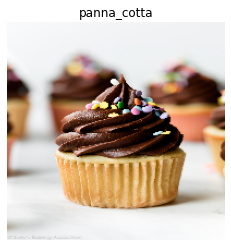

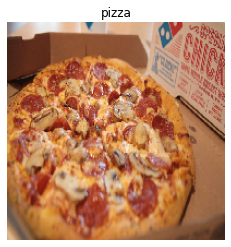

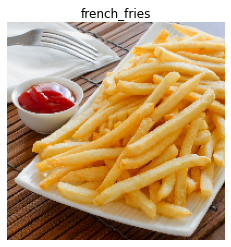

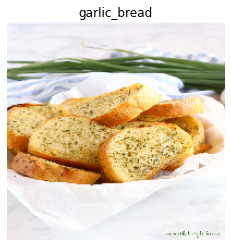

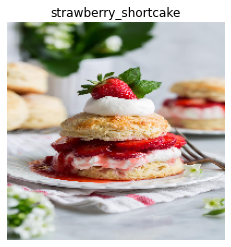

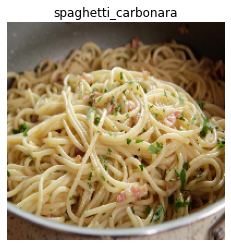

In [66]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(200, 200))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = img / 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    pred_value = foods_sorted[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = ['cupcakes.jpg', 'pizza.jpg', 'frenchfries.jpg', 'garlicbread.jpg', 'strawberryshortcake.jpg', 'speghetticarbonara.jpg']
predict_class(model_best, images, True)